# Energy Based Classification for MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np


### Load Data

### Training

In [2]:
use_cuda = torch.cuda.is_available()  # not no_cuda and
batch_size = 100 #100
test_batch_size = 1000
lr = 0.02
gamma = 0.8 #0.8
epochs = 10
seed = np.random.randint(0, 1000)
torch.manual_seed(seed)
np.random.seed(seed)

out = 1
n_classes = 10

In [3]:
class H1(nn.Module):
    # Hamiltonian neural network, as presented in [1,2].
    # H_1-DNN and H_2-DNN
    # General ODE: \dot{y} = J(y,t) K(t) \tanh( K^T(t) y(t) + b(t) )
    # Constraints:
    #   J(y,t) = J_1 = [ 0 I ; -I 0 ]  or  J(y,t) = J_2 = [ 0 1 .. 1 ; -1 0 .. 1 ; .. ; -1 -1 .. 0 ].
    # Discretization method: Forward Euler
    def __init__(self, n_layers, t_end, nf, random=True, select_j='J1',n_classes=5):
        super().__init__()

        self.n_layers = n_layers  # nt: number of layers
        self.h = t_end / self.n_layers  #interval
        self.act = nn.Tanh()    # activation function
        self.nf = nf            # number of features
        self.n_classes = n_classes # number of classes
        self.Y_ALL = []

        if random:
            K = torch.randn(self.nf, self.nf, self.n_layers-1)
            b = torch.randn(self.nf, 1, self.n_layers-1)
            final_K = torch.randn(self.nf, self.n_classes,1)
            final_b = torch.randn(self.n_classes, 1, 1)
        else:
            K = torch.ones(self.nf, self.nf, self.n_layers-1)
            b = torch.zeros(self.nf, 1, self.n_layers-1)
            final_K = torch.ones(self.nf, self.n_classes, 1)
            final_b = torch.zeros(self.n_classes, 1, 1)
        
        self.K = nn.Parameter(K, True)
        self.b = nn.Parameter(b, True)
        self.final_K = nn.Parameter(final_K, True)
        self.final_b = nn.Parameter(final_b, True)

        if select_j == 'J1':
            j_identity = torch.eye(self.nf//2)
            j_zeros = torch.zeros(self.nf//2, self.nf//2)
            self.J = torch.cat((torch.cat((j_zeros, j_identity), 0), torch.cat((- j_identity, j_zeros), 0)), 1)
        else:
            j_aux = np.hstack((np.zeros(1), np.ones(self.nf-1)))
            J = j_aux
            for j in range(self.nf-1):
                j_aux = np.hstack((-1 * np.ones(1), j_aux[:-1]))
                J = np.vstack((J, j_aux))
            self.J = torch.tensor(J, dtype=torch.float32)

    def getK(self):
        return self.K

    def getb(self):
        return self.b

    def getJ(self):
        return self.J

    def getY_ALL(self):
        return self.Y_ALL

    def forward(self, Y0, ini=0, end=None):

        dim = len(Y0.shape)
        Y = Y0.transpose(1, dim-1)

        if end is None:
            end = self.n_layers
        
        self.Y_ALL = []
        for j in range(ini, end-1):
            Y = Y + self.h * F.linear(self.act(F.linear(
                Y, self.K[:, :, j].transpose(0, 1), self.b[:, 0, j])), torch.matmul(self.J, self.K[:, :, j]))
            
            self.Y_ALL.append(Y)
            
        NNoutput = Y.transpose(1, dim-1)

        return NNoutput, self.K, self.b

In [4]:
def logcos(x):
    return x + torch.log(1+torch.exp(-2.0*x)) - torch.log(torch.tensor(2.0))
    # return torch.abs(x) + torch.log(1+torch.exp(-2.0*torch.abs(x))) - torch.log(torch.tensor(2.0))

In [5]:
def compute_H(y,K,b):
    dim = len(y.shape)
    y = y.transpose(1, dim-1)
    n_layers = K.shape[-1]

    # print('compute h:')
    # print('state:',y.squeeze(2).shape)
    # print("K:",K[:, :, n_layers-1].transpose(0, 1).shape)
    # print('b:',b[:, 0, n_layers-1].shape)

    H = torch.sum(logcos(F.linear(
                y.squeeze(2), K[:, :, n_layers-1].transpose(0, 1), b[:, 0, n_layers-1])),dim-1)
    return H

In [6]:
def compute_all_H(y,K,b):
  H_ALL = []
  
  n_layers = K.shape[-1]
  
  for layer in range(n_layers):
    dim = len(y[layer].shape)
    current_state = y[layer]

    # print('state:',current_state.squeeze(2).shape)
    # print("K:",K[:, :, layer].transpose(0, 1).shape)
    # print('b:',b[:, 0, layer].shape)

    H_ALL.append(torch.sum(torch.log(torch.cosh(F.linear(
                current_state.squeeze(2), K[:, :, layer].transpose(0, 1), b[:, 0, layer]))),dim-1))
  
  return H_ALL

In [7]:
class Net_Energy(nn.Module):
    def __init__(self, nf=8, n_layers=4, h=0.5, net_type='H1_J1'):
        super(Net_Energy, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=nf, kernel_size=3, stride=1, padding=1)
        self.hamiltonian = H1(n_layers=n_layers, t_end=h * n_layers, nf=nf, select_j='J1')
        self.fc_end = nn.Linear(28*28,10)
        self.nf = nf
        self.H = []
        self.H_ALL = []
    
    def get_all_H(self):
        return self.H_ALL

    def getH(self):
        return self.H

    def forward(self, x):
        x = self.conv1(x)
        x,K,b = self.hamiltonian(x)

        self.H = compute_H(x,K,b)

        all_states = self.hamiltonian.getY_ALL()
        # print('Y all:',len(all_states))
        # print('K:',K.shape)
        self.H_ALL = compute_all_H(all_states,K,b)

        x = self.H.reshape(-1,28*28)
        output = self.fc_end(x)
        # output = F.log_softmax(x, dim=1)
        return output

In [8]:
# Define the net model
n_layers = 4
net_type = 'H1_J1'

h = 0.4
wd = 4e-3
alpha = 8e-3
alpha_H = 1e-3 #1e-5


device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 20, 'pin_memory': True} if use_cuda else {}
model = Net_Energy(nf=8, n_layers=n_layers, h=h, net_type=net_type).to(device)

print("\n------------------------------------------------------------------")
print("MNIST dataset - %s-DNN - %i layers" % (net_type, n_layers))
print("== sgd with Adam (lr=%.1e, weight_decay=%.1e, gamma=%.1f, max_epochs=%i, alpha=%.1e, minibatch=%i)" %
      (lr, wd, gamma, epochs, alpha, batch_size))

best_acc = 0
best_acc_train = 0


------------------------------------------------------------------
MNIST dataset - H1_J1-DNN - 4 layers
== sgd with Adam (lr=2.0e-02, weight_decay=4.0e-03, gamma=0.8, max_epochs=10, alpha=8.0e-03, minibatch=100)


In [9]:
# Load train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
# Load test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [10]:
# Define optimization algorithm
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# Scheduler for learning_rate parameter
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [11]:
def regularization(alpha, h, K, b, H_ALL, alpha_H):
    # Regularization function as introduced in [1]
    n_layers = K.shape[-1]
    loss = 0
    for j in range(n_layers - 1):
        loss = loss + alpha * h * (1 / 2 * torch.norm(K[:, :, j + 1] - K[:, :, j]) ** 2 +
                                   1 / 2 * torch.norm(b[:, :, j + 1] - b[:, :, j]) ** 2) + alpha_H * h *  1 / 2 * torch.norm(H_ALL[j+1] - H_ALL[j]) ** 2
    return loss

In [12]:
def train(model, device, train_loader, optimizer, epoch, alpha, out, alpha_H):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        K = model.hamiltonian.getK()
        b = model.hamiltonian.getb()
        H_ALL = model.get_all_H()
        # for j in range(int(model.hamiltonian.n_layers) - 1):
        loss = loss + regularization(alpha, h, K, b, H_ALL, alpha_H)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and out>0:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            print('\tTrain Epoch: {:2d} [{:5d}/{} ({:2.0f}%)]\tLoss: {:.6f}\tAccuracy: {}/{}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), correct, len(data)))

In [13]:
def test(model, device, test_loader, out):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    if out > 0:
        print('Test set:\tAverage loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return correct

In [14]:
for epoch in range(1, epochs + 1):
  train(model, device, train_loader, optimizer, epoch, alpha, out, alpha_H)
  test_acc = test(model, device, test_loader, out)
  # Results over training set after training
  train_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in train_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          train_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
  train_loss /= len(train_loader.dataset)
  if out > 0:
      print('Train set:\tAverage loss: {:.4f}, Accuracy: {:5d}/{} ({:.2f}%)'.format(
          train_loss, correct, len(train_loader.dataset),
          100. * correct / len(train_loader.dataset)))
  scheduler.step()
  if best_acc < test_acc:
      best_acc = test_acc
      best_acc_train = correct

print("\nNetwork trained!")
print('Test accuracy: {:.2f}%  - Train accuracy: {:.3f}% '.format(
      100. * best_acc / len(test_loader.dataset), 100. * best_acc_train / len(train_loader.dataset)))
print("------------------------------------------------------------------\n")



	Train Epoch:  1 [    0/60000 ( 0%)]	Loss: 4827.464355	Accuracy: 21/100
	Train Epoch:  1 [10000/60000 (17%)]	Loss: 20.581362	Accuracy: 76/100
	Train Epoch:  1 [20000/60000 (33%)]	Loss: 8.923359	Accuracy: 75/100
	Train Epoch:  1 [30000/60000 (50%)]	Loss: 5.668339	Accuracy: 86/100
	Train Epoch:  1 [40000/60000 (67%)]	Loss: 4.675148	Accuracy: 81/100
	Train Epoch:  1 [50000/60000 (83%)]	Loss: 2.486798	Accuracy: 79/100
Test set:	Average loss: 2.1086, Accuracy:  8421/10000 (84.21%)
Train set:	Average loss: 2.3424, Accuracy: 50188/60000 (83.65%)
	Train Epoch:  2 [    0/60000 ( 0%)]	Loss: 3.537511	Accuracy: 87/100
	Train Epoch:  2 [10000/60000 (17%)]	Loss: 2.933477	Accuracy: 83/100
	Train Epoch:  2 [20000/60000 (33%)]	Loss: 1.879354	Accuracy: 87/100
	Train Epoch:  2 [30000/60000 (50%)]	Loss: 1.909996	Accuracy: 84/100
	Train Epoch:  2 [40000/60000 (67%)]	Loss: 3.209017	Accuracy: 86/100
	Train Epoch:  2 [50000/60000 (83%)]	Loss: 1.623357	Accuracy: 89/100
Test set:	Average loss: 1.7634, Accuracy:

In [15]:
torch.save(model,'Net_Energy_reg_1e-3.pkl') 


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []
H_pred = []
inputs_all = []

# iterate over test data
for inputs, labels in test_loader:
        output,H = model(inputs) # Feed Network
        H_pred.extend(H)

        inputs_all.extend(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
cf_matrix_per = np.zeros((10,10))
cf_matrix_char = np.chararray((10, 10))
for i in range(10):
  cf_matrix_per[i] = cf_matrix[i] / np.sum(cf_matrix[i])

for i in range(10):
  for j in range(10):
    cf_matrix_char[i][j] = "{:.2%}".format(cf_matrix_per[i][j])

In [ ]:
cf_matrix_per[i] = (cf_matrix[i] / np.sum(cf_matrix[i]))

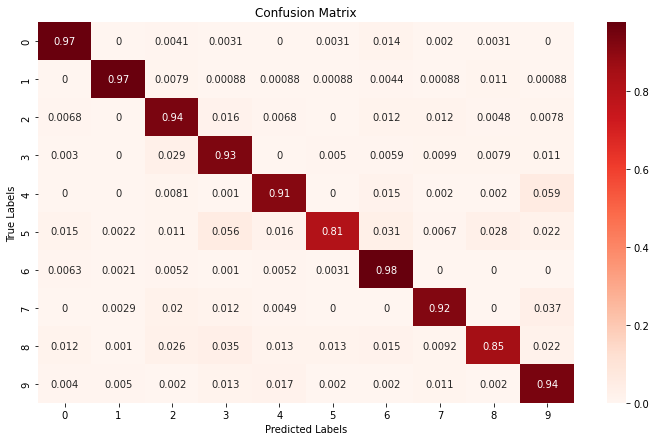

In [ ]:
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix_per, annot=True,cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig('output.png')

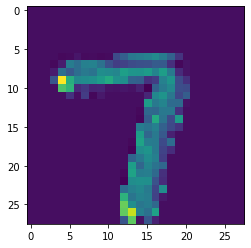

In [ ]:
plt.imshow(H_pred[1].data.numpy().T)

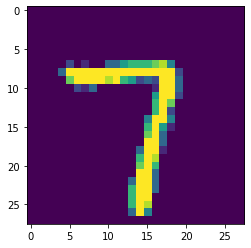

In [ ]:
plt.imshow(inputs_all[1].squeeze(0).data.numpy())

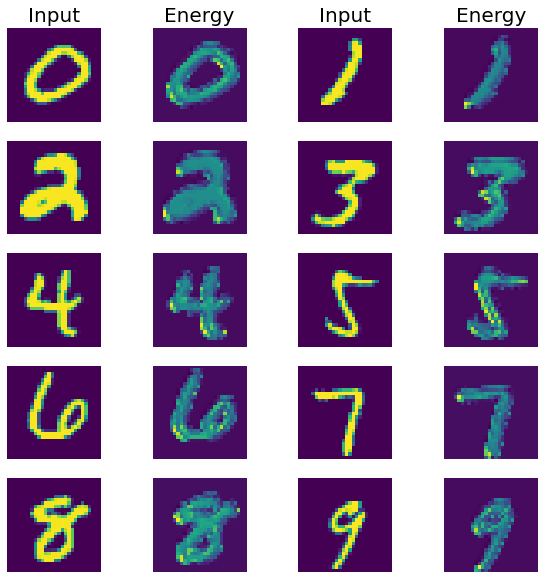

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
  for j in range(200):
    if y_true[j] == i:
      H = H_pred[j]
      inp = inputs_all[j]
      break
  ax = fig.add_subplot(5, 4, 2*i+1)
  ax.imshow(inp.squeeze(0).data.numpy())
  ax.axis('off')
  if i<=1:
    ax.set_title('Input', fontsize=20)
  ax = fig.add_subplot(5, 4, 2*i+2)
  ax.axis('off')
  if i<=1:
    ax.set_title('Energy', fontsize=20)
  ax.imshow(H.data.numpy().T)
  

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output,H = model(data)
        loss = F.nll_loss(output, target)
        K = model.hamiltonian.getK()
        b = model.hamiltonian.getb()
        H_ALL = model.get_all_H()
        break

In [ ]:
H.shape

torch.Size([100, 28, 28])

In [ ]:
H_ALL[0].shape

torch.Size([100, 28, 28])

In [ ]:
s = '07:05:45PM'
str(int(s[0:2])+12)

'19'

In [ ]:
s[8:]

'PM'